In [103]:
import tensorflow as tf
import numpy as np
from numpy.random import seed
seed(1)
tf.random.set_seed(1)


import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
# import pickle
# from tensorflow.keras import backend as K
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation, Input
from efficientnet.tfkeras import EfficientNetB0

In [104]:
# from cifar10_vgg_selectivenet import *
class Cifar10Vgg:
    def __init__(self, input_dim, num_classes = 10,filename="weightsvgg.h5", coverage=0.8, alpha=0.5,train=True,
                 baseline=False):
        self.lamda = coverage
        self.alpha = alpha
        self.mc_dropout_rate = K.variable(value=0.1)
        self.num_classes = num_classes
        self.weight_decay = 0.0005

        self.x_shape = input_dim
        self.filename = filename

        self.model = self.build_model()
        if baseline:
            self.alpha = 0
              
        if(train & os.path.isfile("saved_data/{}".format(self.filename))):
            self.model.load_weights("saved_data/{}".format(self.filename))

    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
        weight_decay = self.weight_decay
        basic_dropout_rate = 0.3
        input = Input(shape=self.x_shape)
        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(input)
        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate)(curr)

        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)

        curr = Flatten()(curr)
        curr = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)
        curr = Lambda(lambda x: K.dropout(x, level=self.mc_dropout_rate))(curr)

        # classification head (f)
        curr1 = Dense(self.num_classes, activation='softmax')(curr)

        # selection head (g)
        curr2 = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(curr)
        curr2 = Activation('relu')(curr2)
        curr2 = BatchNormalization()(curr2)
        # this normalization is identical to initialization of batchnorm gamma to 1/10
        curr2 = Lambda(lambda x: x / 10)(curr2)
        curr2 = Dense(1, activation='sigmoid')(curr2)
        # auxiliary head (h)
        selective_output = Concatenate(axis=1, name="selective_head")([curr1, curr2])

        auxiliary_output = Dense(self.num_classes, activation='softmax', name="classification_head")(curr)

        model = Model(inputs=input, outputs=[selective_output, auxiliary_output])

        self.input = input
#         self.model_embeding = Model(inputs=input, outputs=curr)
        return model


    def predict(self,x):
        return self.model.predict(x)

#     def predict_embedding(self, x=None, batch_size=128):
#         if x is None:
#             x = self.x_test
#         return self.model_embeding.predict(x, batch_size)

    def mc_dropout(self, batch_size=1000, dropout=0.5, iter=100):
        K.set_value(self.mc_dropout_rate, dropout)
        repititions = []
        for i in range(iter):
            _, pred = self.model.predict(self.x_test, batch_size)
            repititions.append(pred)
        K.set_value(self.mc_dropout_rate, 0)

        repititions = np.array(repititions)
        mc = np.var(repititions, 0)
        mc = np.mean(mc, -1)
        return -mc

    def selective_risk_at_coverage(self, coverage, mc=False):
        _, pred = self.predict()

        if mc:
            sr = np.max(pred, 1)
        else:
            sr = self.mc_dropout()
        sr_sorted = np.sort(sr)
        threshold = sr_sorted[pred.shape[0] - int(coverage * pred.shape[0])]
        covered_idx = sr > threshold
        selective_acc = np.mean(np.argmax(pred[covered_idx], 1) == np.argmax(self.y_test[covered_idx], 1))
        return selective_acc

    def train(self, model, train_images,train_labels):
        c = self.lamda
        lamda = 32

        def selective_loss(y_true, y_pred):
            em_c =K.mean(y_pred[:, -1])
            loss = K.categorical_crossentropy(
                K.repeat_elements(y_pred[:, -1:], self.num_classes, axis=1) * y_true[:, :],
                y_pred[:, :-1]) + lamda * K.maximum(-em_c + c, 0) ** 2 
            return loss

        def selective_acc(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], 0.5), K.floatx())
            temp1 = K.sum(
                (g) * K.cast(K.equal(K.argmax(y_true[:, :-1], axis=1), K.argmax(y_pred[:, :-1], axis=1)), K.floatx()))
            temp1 = temp1 / K.sum(g)
            return K.cast(temp1, K.floatx())

        def coverage(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], 0.5), K.floatx())
            return K.mean(g)

        # training parameters
        batch_size = 32
        maxepoches = 300
        learning_rate = 0.1
        stepsperepoch=5000// batch_size

        lr_decay = 1e-6

        lr_drop = 25

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        early_stop_callback=tf.keras.callbacks.EarlyStopping(
            monitor='loss', min_delta=0.0001, patience=5, restore_best_weights=True
        )
        # optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

        model.compile(loss=[selective_loss, 'categorical_crossentropy'], loss_weights=[self.alpha, 1 - self.alpha],
                      optimizer=sgd, metrics=['accuracy', selective_acc, coverage])

        historytemp = model.fit(train_images,train_labels,
                                  steps_per_epoch=stepsperepoch,
                                  epochs=maxepoches,validation_split=0.2, callbacks=[reduce_lr])

         
#         with open("checkpoints/{}_history.pkl".format(self.filename[:-3]), 'wb') as handle:
#             pickle.dump(historytemp.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

        model.save_weights("saved_data/{}".format(self.filename))
        self.model=model
        return historytemp

    def get_model(self):
        return self.model
    
    def set_model(self, model):
            self.model=model

### Download dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
total_train=train_images.shape[0]
total_test=test_images.shape[0]
print(total_train,total_test)

50000 10000


In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
STEPS_PER_EPOCH=total_train/BATCH_SIZE

In [6]:
num_class=len(CLASS_NAMES)
num_class

10

In [7]:
tr_labels = np.zeros((train_labels.shape[0],num_class), dtype='float32')
ts_labels = np.zeros((test_labels.shape[0],num_class), dtype='float32')
tr_labels[np.arange(total_train),train_labels[:, 0]] = 1
ts_labels[np.arange(total_test),test_labels[:, 0]] = 1
tr_labels.shape

(50000, 10)

In [8]:
 # data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, validation_split=0.2)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(train_images)

In [9]:
def show_batch(image_batch, label_batch,classnames):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(classnames[np.where(label_batch[n])[0][0]])
        plt.axis('off')

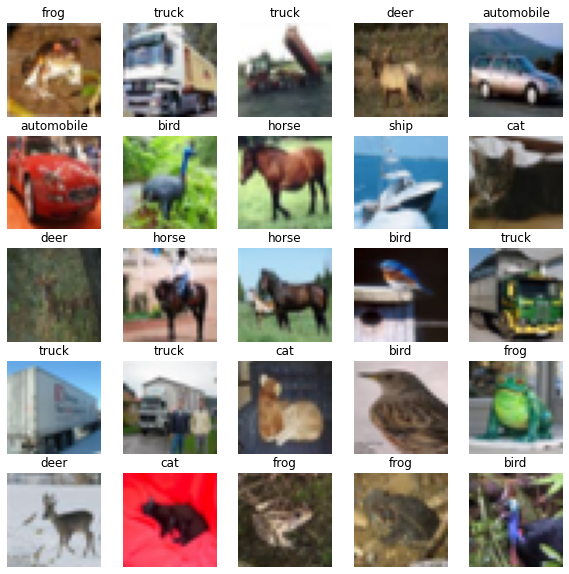

In [10]:
show_batch(train_images, tr_labels,CLASS_NAMES)

### Define Selectivenet

In [11]:
c = 0.8
alpha = 0.5
weights ="weightsvgg.h5"

In [12]:
cifar10_selectivenet = Cifar10Vgg(IMG_SHAPE, num_classes=num_class,
                                    filename=weights, coverage=c, alpha=alpha, train=False, baseline=False)
# cifar10_selectivenet.get_model().summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [14]:
history = cifar10_selectivenet.train(cifar10_selectivenet.get_model(),train_images=train_images,train_labels=tr_labels)

In [15]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle
import seaborn as sns

from selectivnet_utils import *
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
save_dir='saved_data'
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/cifar10_vgg_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [18]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [19]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

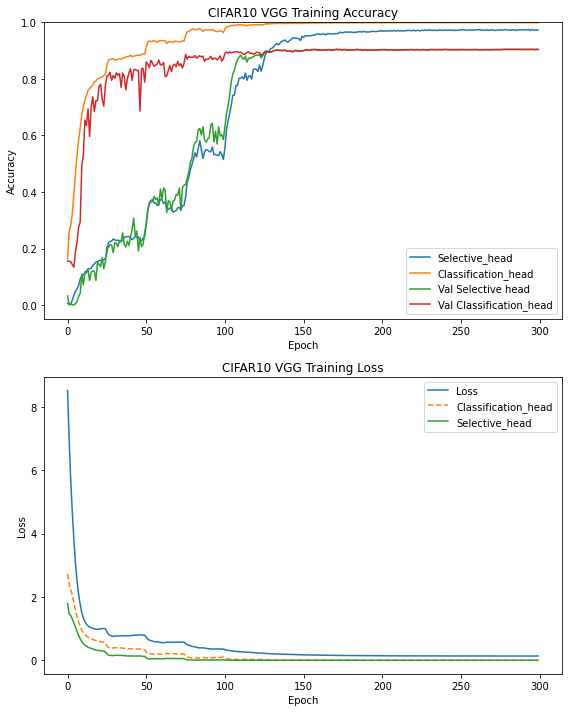

In [20]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 VGG Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 VGG Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

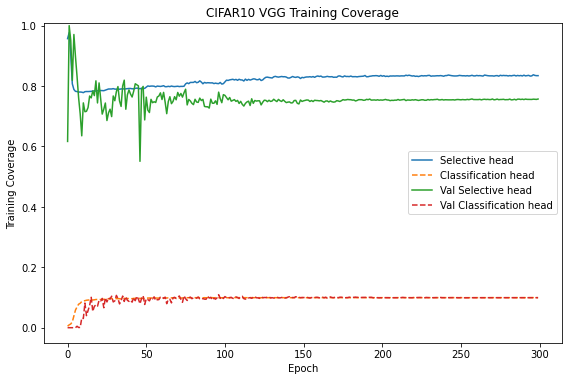

In [21]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CIFAR10 VGG Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [22]:
predictions= cifar10_selectivenet.predict(test_images) #set predictions for use

In [23]:
print("Shape of selective head predictions: ",predictions[1].shape)
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (10000, 10)
Selective head predictions:  (10000,)


In [27]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Accuracy:",acc)
print("Classification Accuracy:",aux_acc)

Accuracy: 0.9002
Classification Accuracy: 0.9


In [33]:
coverages = np.arange(0.5,1.05,0.05) # coverages
sel_coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sel_coverage_risk[i] = selective_risk(c,ts_labels,predictions[1],predictions[0][:,-1]) #coverage_risk[0]
    i=i+1

sel_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sel_sr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions[1],mc=True)
    i=i+1   

In [39]:
sel_coverage_risk

array([[0.4996    , 0.0030024 , 0.9969976 ],
       [0.55      , 0.00454545, 0.99545455],
       [0.6       , 0.00633333, 0.99366667],
       [0.65      , 0.01      , 0.99      ],
       [0.7       , 0.01271429, 0.98728571],
       [0.75      , 0.01813333, 0.98186667],
       [0.8       , 0.026375  , 0.973625  ],
       [0.85      , 0.04035294, 0.95964706],
       [0.9       , 0.05955556, 0.94044444],
       [0.95      , 0.07947368, 0.92052632],
       [0.9999    , 0.10001   , 0.89999   ]])

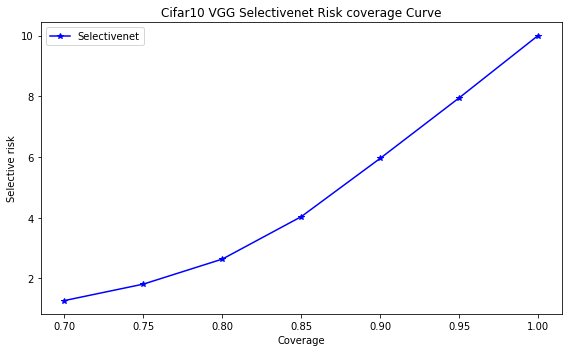

In [34]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,sel_sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='Classification head')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 VGG Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

### Baseline Model

In [35]:
baseline = "cifar10_baseline_vgg.h5"

In [37]:
cifar10_selectivenet_base = Cifar10Vgg(IMG_SHAPE, num_classes=num_class,
                                    filename=baseline, coverage=c, alpha=alpha, train=False, baseline=True)

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [45]:
history = cifar10_selectivenet_base.train(cifar10_selectivenet.get_model(),train_images=train_images, train_labels=tr_labels)

In [40]:
history_header =",".join(["classification_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","classification_head_loss", "selective_head_loss", "classification_head_coverage", 
                  "selective_head_coverage","val_classification_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_classification_head_loss", "val_selective_head_loss",
                  "val_classification_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/basemodel_cifar10_vgg_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [41]:
a=np.array([
    history.history['classification_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['classification_head_loss'],
    history.history['selective_head_loss'],
    history.history['classification_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_classification_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_classification_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_classification_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

In [42]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

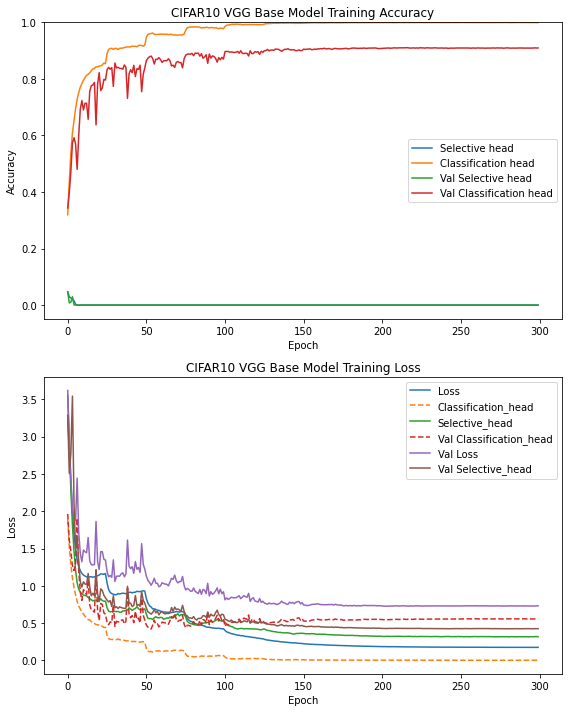

In [43]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_accuracy'],linestyle='-', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_accuracy'],linestyle='-', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 VGG Base Model Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['classification_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_classification_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 VGG Base Model Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

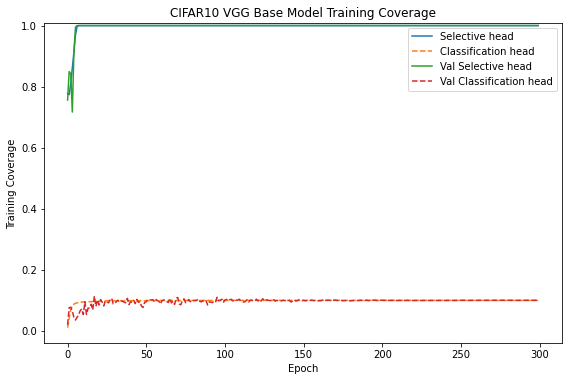

In [44]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['classification_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_classification_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CIFAR10 VGG Base Model Training Coverage')
plt.tight_layout()
plt.show()

In [46]:
predictions= cifar10_selectivenet_base.predict(test_images) #set predictions for use

In [47]:
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("BR predictions: ",y_pred.shape)      

BR predictions:  (10000,)


In [48]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
print("BR Accuracy:",acc)
acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("BR Classification head Accuracy:",acc)

BR Accuracy: 0.0
BR Classification head Accuracy: 0.9031


In [49]:
coverages = np.arange(0.5,1.05,0.05) # coverages
br_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_coverages_risk[i]= selective_risk(c,ts_labels,predictions[1],predictions[0][:,-1])
    i=i+1

br_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    br_sr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions[1],mc=True)
    i=i+1

In [50]:
br_sr_coverages_risk

array([[0.4998    , 0.00340136, 0.99659864],
       [0.5492    , 0.00400583, 0.99599417],
       [0.5999    , 0.00550092, 0.99449908],
       [0.6498    , 0.00784857, 0.99215143],
       [0.6999    , 0.01028718, 0.98971282],
       [0.7499    , 0.01653554, 0.98346446],
       [0.7999    , 0.0256282 , 0.9743718 ],
       [0.8499    , 0.03682786, 0.96317214],
       [0.8999    , 0.05167241, 0.94832759],
       [0.9499    , 0.0723234 , 0.9276766 ],
       [0.9999    , 0.09680968, 0.90319032]])

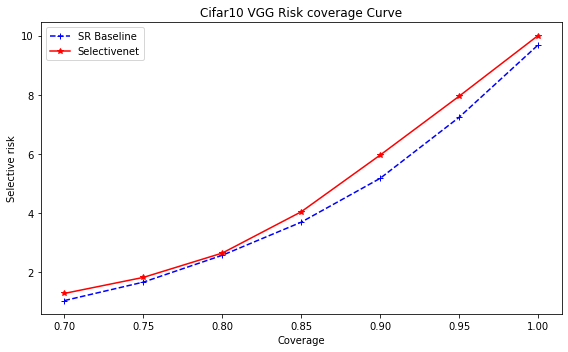

In [319]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,br_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],sel_coverage_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,sel_sr_coverages_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [52]:
# from vgg_SR import vgg_SR_build_model
def vgg_SR_build_model(input_dim, num_classes,weight_decay,mc_dropout_rate):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.
        weight_decay = weight_decay
        basic_dropout_rate = 0.3
        input = Input(shape=input_dim)
        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(input)
        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate)(curr)

        curr = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.1)(curr)

        curr = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = MaxPooling2D(pool_size=(2, 2))(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)

        curr = Flatten()(curr)
        curr = Dense(512, kernel_regularizer=regularizers.l2(weight_decay))(curr)

        curr = Activation('relu')(curr)
        curr = BatchNormalization()(curr)
        curr = Dropout(basic_dropout_rate + 0.2)(curr)
        curr = Lambda(lambda x: K.dropout(x, level=mc_dropout_rate))(curr)


        auxiliary_output = Dense(num_classes, activation='softmax', name="classification_head")(curr)

        model = Model(inputs=input, outputs=auxiliary_output)
        
        learning_rate = 0.1
        
        lr_decay = 1e-6


        # optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)

        model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

        return model

In [55]:
sr_model=vgg_SR_build_model(input_dim=IMG_SHAPE, num_classes=len(CLASS_NAMES),weight_decay=0.0005,mc_dropout_rate=0.1)

In [194]:
# sr_model.summary()

In [60]:
batch_size = 32
maxepoches = 300
stepsperepoch=5000// batch_size
learning_rate = 0.1
lr_drop = 25
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [62]:
historytemp = sr_model.fit(train_images, tr_labels,
                          steps_per_epoch=stepsperepoch,
                          epochs=maxepoches,validation_split=0.2, callbacks=[reduce_lr])

In [63]:
sr_model.save_weights("saved_data/{}".format('cifar10_vgg_SR.h5'))

In [64]:
header =",".join(["accuracy","loss","val_accuracy", "val_loss\n"])
sr_history=save_dir+'/cifar10_vgg_sr_history.csv'
# f=open(sr_history,"w")
# f.write(header)
# f.close()

In [65]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [66]:
sr_curve=pd.read_csv(sr_history)

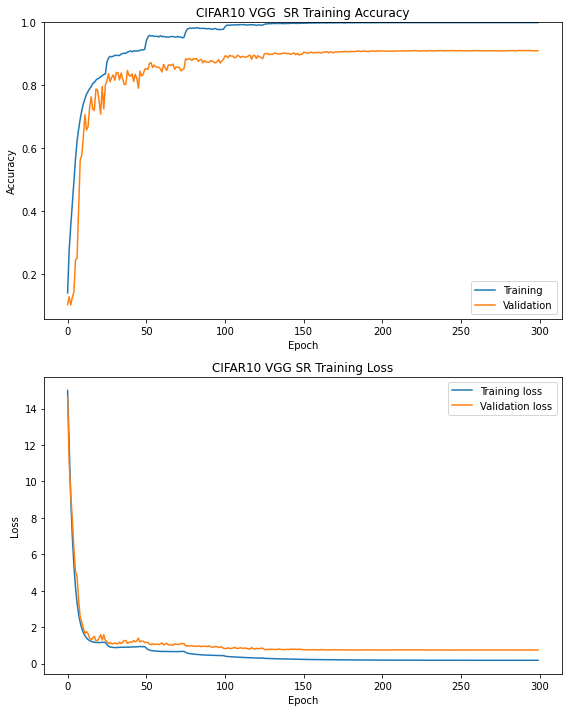

In [67]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 VGG  SR Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 VGG SR Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [83]:
predictions= sr_model.predict(test_images) #set predictions for use

In [84]:
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (10000,)


In [85]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.8981


In [86]:
sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions,mc=True)
    i=i+1

In [87]:
sr_coverages_risk

array([[0.4994    , 0.00380457, 0.99619543],
       [0.549     , 0.00491803, 0.99508197],
       [0.5995    , 0.00667223, 0.99332777],
       [0.6492    , 0.0107825 , 0.9892175 ],
       [0.6998    , 0.01471849, 0.98528151],
       [0.7499    , 0.02066942, 0.97933058],
       [0.7999    , 0.0280035 , 0.9719965 ],
       [0.8499    , 0.04118132, 0.95881868],
       [0.8999    , 0.05622847, 0.94377153],
       [0.9499    , 0.07653437, 0.92346563],
       [0.9999    , 0.10181018, 0.89818982]])

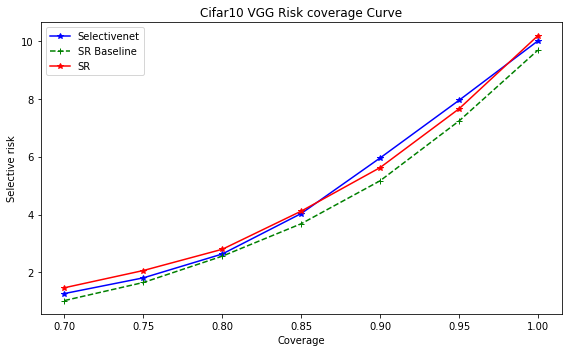

In [317]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],sel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,sel_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,br_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],br_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],sr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 VGG Risk coverage Curve')
plt.tight_layout()
plt.show()

In [174]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation, Input
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import backend as K

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

class SelectiveNet:
    def __init__(self,dropout=0.2, mc_dropout = 0.2,num_classes=1,
               training=True, input_dim=(224,224,3),pooling="avg"):
        self.c = 0.75
        self.lamda = 32
        self.alpha = 0.5
        self.dropout = dropout
        self.mc_dropout = mc_dropout
        self.pooling = pooling
        self.input_dim = input_dim
        self.training = training
        self.num_classes = num_classes
        
        #create model
        inputs=Input(shape=self.input_dim)
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
        base_model.trainable=True
        x = base_model.output
        x = Dropout(self.dropout, name='top_dropout_1')(x,training=self.training)
        if pooling == 'avg':
            x = GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D(name='max_pool')(x)   
        x = Dropout(self.dropout, name='top_dropout_2')(x,training=self.training)
        x = Dense(512,activation='relu', name='dense_512')(x)
        x = BatchNormalization()(x)
        x = Dropout(self.mc_dropout, name='top_dropout_3')(x,training=self.training)
        x = Lambda(lambda x: K.dropout(x, level=self.mc_dropout))(x)

        #classification head (f)
        f = Dense(self.num_classes,activation='softmax', name='f_head')(x)

        #selection head (g)
        g = Dense(512, activation='relu', name='dense_512_g')(x)
        g = BatchNormalization()(g)
        # this normalization is identical to initialization of batchnorm gamma to 1/10
        g = Lambda(lambda a: a / 10)(g)
        g = Dense(1, activation='sigmoid',name='g_head')(g)

        # auxiliary head (h)
        selective_output = Concatenate(axis=1, name="selective_head")([f, g])


        auxillary_output = Dense(self.num_classes,activation='softmax', name='auxilary_head')(x)


        self.model = Model(inputs=inputs,outputs=[selective_output,auxillary_output])
        

    def compile_model(self,c=0.75, lamda=32, alpha=0.5,tau=0.5,lr=0.01,decay=1e-6,momentum=0.9):
        self.c = c
        self.lamda = lamda
        self.alpha = alpha
        def coverage(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], tau), K.floatx())
            return K.mean(g)

        def selective_loss(y_true, y_pred):
            em_coverage = K.mean(y_pred[:, -1])
            loss = K.categorical_crossentropy(K.repeat_elements(y_pred[:, -1:], self.num_classes, axis=1) * y_true[:,:],
                    y_pred[:, :-1]) + self.lamda * K.maximum(-em_coverage + self.c, 0) ** 2
            return loss

        def selective_acc(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], tau), K.floatx())
            temp1 = K.sum(
                (g) * K.cast(K.equal(K.argmax(y_true[:,:-1], axis=1), K.argmax(y_pred[:, :-1], axis=1)), 
                             K.floatx()))
            temp1 = temp1 / K.sum(g)
            return K.cast(temp1, K.floatx())
    
        sgd = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
        self.model.compile(loss=[selective_loss, 'categorical_crossentropy'], loss_weights=[self.alpha, 1 - self.alpha],
                      optimizer=sgd, metrics=['accuracy', selective_acc, coverage])
    
    def model_train(self, train_images, train_labels, EPOCHS, val_ds=None, initial_epoch=0, shuffle=True, callbacks = [], 
                    verbose = 2):
#         steps_per_epoch=5000/32,
        if(val_ds):
            history =self.model.fit(
                train_images,
                train_labels,
                initial_epoch=initial_epoch,
                steps_per_epoch=10000/32,
                epochs=EPOCHS,
                validation_data=val_ds,
                shuffle=shuffle,
                verbose = verbose,
                callbacks=callbacks
            )
        else:
            history = self.model.fit(
                train_images,
                train_labels,
                initial_epoch=initial_epoch,
                epochs=EPOCHS,
                validation_split=0.2,
                steps_per_epoch=10000/32,
                shuffle=shuffle,
                verbose = verbose,
                callbacks=callbacks
            )
        return history         
            
    def classification_predict(self, test):
        predictions= self.model.predict(test)
        return predictions

    def mc_dropout(self,test_ds,iter=100):
        for i in range(iter):
            mc_predictions = self.classification_predict(test_ds)
        selective_head = np.mean(mc_predictions[0],1)
        classification_head =np.mean(mc_predictions[1],1)
        return np.array([selective_head,classification_head])

    def selective_risk(self,c,y_true,y_pred):
        if(100*(1-c)<0):
            q = 0
        elif(100*(1-c)>100):
            q =100
        else:
            q =100*(1-c)
        threshold = np.percentile(y_pred[:,-1],q)
        covered_indx = y_pred[:, -1] > threshold
        g = covered_indx.astype('int')
        coverage = np.mean(g)
        acc = np.sum( np.equal( np.argmax(y_pred[:, :self.num_classes],axis=1), 
                                 np.argmax(y_true[:, :-1], axis=1))) / np.sum(g)

        risk = 1-acc
        return coverage, risk, acc

    def sr_selective_risk(self,c, y_true, y_pred):
       
        sr = np.max(y_pred[:,:self.num_classes], axis=1)
        sr_sorted = np.sort(sr)
        threshold = sr_sorted[sr.shape[0] - int(c * sr.shape[0])]
        covered_indx = sr > threshold
        g = covered_indx.astype('int')
        coverage = np.mean(g)
        acc = np.sum( np.equal( np.argmax(y_pred[:, :self.num_classes],axis=1), 
                                 np.argmax(y_true[:, :-1], axis=1))) / np.sum(g)
        risk = 1-acc
        return coverage, risk, acc
    
    
    def get_model(self):
        return self.model

    def set_model_weights(self,filename):
        self.model.load_weights(filename)

In [203]:
dropout = 0.2
mc_dropout =0.1
training=True
pooling="avg"
input_dims=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)
learning_rate = 0.01
momentum=0.9
initial_epoch=0
maxepoches=300

lr_decay = 1e-6

In [211]:
lr_drop = 100
def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [205]:
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0001, patience=5, restore_best_weights=True
)

In [287]:
my_selectivenet = SelectiveNet(dropout=dropout, mc_dropout = mc_dropout,num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
my_selectivenet.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.5)

In [304]:
# my_selectivenet.get_model().summary()

In [305]:
history = my_selectivenet.model_train(train_images, tr_labels, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=True, 
                                      verbose=1, callbacks = [reduce_lr])

In [290]:
save_dir='saved_data'
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/cifar10_effnet_history.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [291]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [292]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

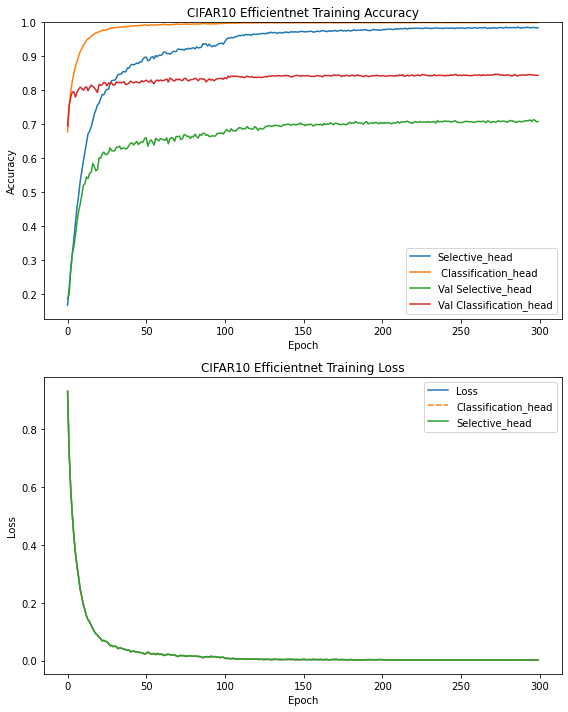

In [293]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 Efficientnet Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
# plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
# plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
# plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 Efficientnet Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

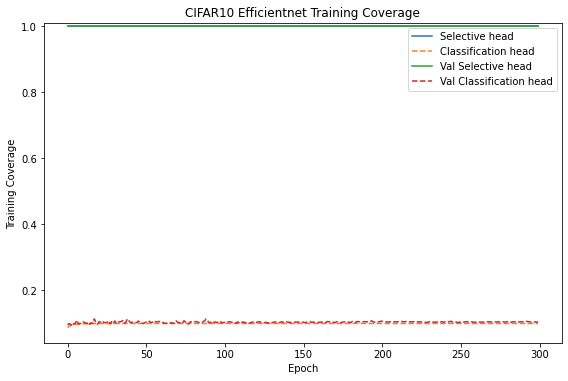

In [294]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CIFAR10 Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [295]:
my_selectivenet.get_model().save_weights(save_dir+'/effnet_sel_model.h5')

In [296]:
# my_selectivenet.set_model_weights(save_dir+'/effnet_sel_model.h5')

In [297]:
predictions = my_selectivenet.classification_predict(test_images) #set predictions for use    

In [298]:
len(predictions)

2

In [299]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions[0],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (10000, 11)
Selective head predictions:  (10000,)


In [300]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("Accuracy:",acc)
print("Classification Accuracy:",aux_acc)

Accuracy: 0.6925
Classification Accuracy: 0.8324


In [301]:
coverages = np.arange(0.5,1.05,0.05) # coverages
esel_coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_coverage_risk[i] = selective_risk(c,ts_labels,predictions[1],predictions[0][:,-1]) #coverage_risk[0]
    i=i+1

esel_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esel_sr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions[1],mc=True)
    i=i+1

In [302]:
esel_coverage_risk

array([[0.5       , 0.0756    , 0.9244    ],
       [0.5499    , 0.08183306, 0.91816694],
       [0.6       , 0.091     , 0.909     ],
       [0.65      , 0.09692308, 0.90307692],
       [0.7       , 0.10514286, 0.89485714],
       [0.75      , 0.11213333, 0.88786667],
       [0.7999    , 0.1207651 , 0.8792349 ],
       [0.8497    , 0.13122278, 0.86877722],
       [0.9       , 0.14222222, 0.85777778],
       [0.9499    , 0.15380566, 0.84619434],
       [0.9999    , 0.16761676, 0.83238324]])

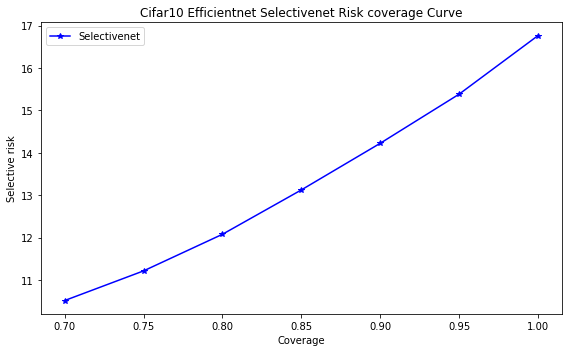

In [303]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='Classification head')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 Efficientnet Selectivenet Risk coverage Curve')
plt.tight_layout()
plt.show()

In [236]:
my_selectivenet_base = SelectiveNet(dropout=0.2, mc_dropout = 0.1,num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
my_selectivenet_base.compile_model(c=c,lr=learning_rate,decay=lr_decay,alpha=0.0)

In [238]:
history = my_selectivenet_base.model_train(train_images, tr_labels, EPOCHS=maxepoches, initial_epoch=initial_epoch, shuffle=True, 
                                      verbose=1, callbacks = [reduce_lr])

In [214]:
history_header =",".join(["auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy", 
                  "val_selective_head_selective_acc", "val_loss", "val_auxilary_head_loss", "val_selective_head_loss",
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/cifar10_basemodel_effnet_history.csv'
f=open(history_fname,"w")
f.write(history_header)
f.close()

In [215]:
a=np.array([
    history.history['auxilary_head_accuracy'],
    history.history['selective_head_accuracy'],
    history.history['selective_head_selective_acc'],
    history.history['loss'],
    history.history['auxilary_head_loss'],
    history.history['selective_head_loss'],
    history.history['auxilary_head_coverage'],
    history.history['selective_head_coverage'],
    history.history['val_auxilary_head_accuracy'],
    history.history['val_selective_head_accuracy'],
    history.history['val_selective_head_selective_acc'],
    history.history['val_loss'],
    history.history['val_auxilary_head_loss'],
    history.history['val_selective_head_loss'],
    history.history['val_auxilary_head_coverage'],
    history.history['val_selective_head_coverage']
]).T
write_csv(history_fname,a)

### Visualize training metrics

In [216]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes basemodel_cifar10_vgg_history

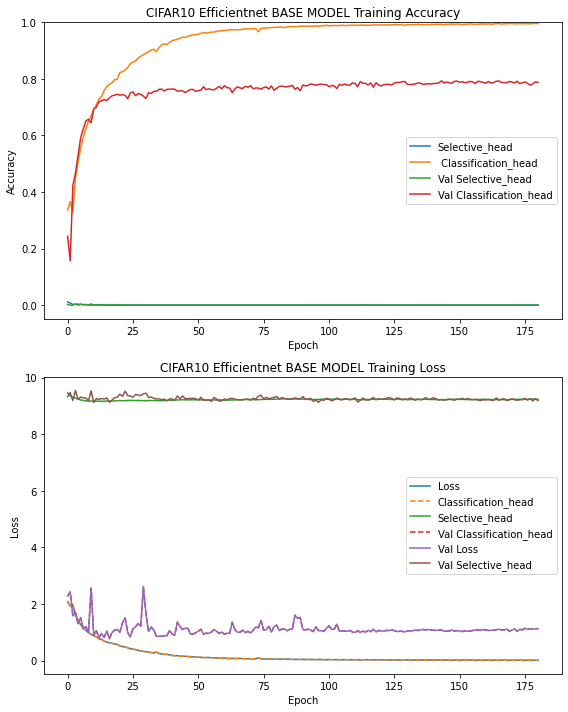

In [217]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_accuracy'],linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['auxilary_head_accuracy'],linestyle='-', label=' Classification_head')
plt.plot(x,lr_curve['val_selective_head_accuracy'],linestyle='-', label='Val Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_accuracy'],linestyle='-', label='Val Classification_head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 Efficientnet BASE MODEL Training Accuracy')

plt.subplot(2, 1, 2)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['loss'], label='Loss')
plt.plot(x,lr_curve['auxilary_head_loss'], linestyle='--', label='Classification_head')
plt.plot(x,lr_curve['selective_head_loss'], linestyle='-', label='Selective_head')
plt.plot(x,lr_curve['val_auxilary_head_loss'], linestyle='--', label='Val Classification_head')
plt.plot(x,lr_curve['val_loss'], linestyle='-', label='Val Loss')
plt.plot(x,lr_curve['val_selective_head_loss'], linestyle='-', label='Val Selective_head')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 Efficientnet BASE MODEL Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

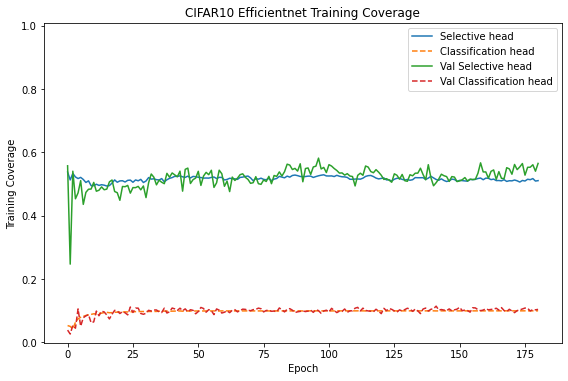

In [218]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(lr_curve.shape[0])
plt.plot(x,lr_curve['selective_head_coverage'],linestyle='-', label='Selective head')
plt.plot(x,lr_curve['auxilary_head_coverage'],linestyle='--', label='Classification head')
plt.plot(x,lr_curve['val_selective_head_coverage'],linestyle='-', label='Val Selective head')
plt.plot(x,lr_curve['val_auxilary_head_coverage'],linestyle='--', label='Val Classification head')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Training Coverage')
plt.ylim([min(plt.ylim()),1.01])
plt.title('CIFAR10 Efficientnet Training Coverage')
plt.tight_layout()
plt.show()

### Make Prediction

In [219]:
my_selectivenet_base.get_model().save_weights(save_dir+'/effnet_base_model.h5')

In [256]:
predictions = my_selectivenet_base.classification_predict(test_images) #set predictions for use    

In [258]:
print("Shape of selective head predictions: ",predictions[0].shape)
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions[1],axis=1)
print("Selective head predictions: ",y_pred.shape)      

Shape of selective head predictions:  (10000, 11)
Selective head predictions:  (10000,)


In [259]:
acc=my_evaluation(y_true,np.argmax(predictions[0],axis=1))
aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
print("BR Accuracy:",acc)
print("BR Classification Accuracy:",aux_acc)

BR Accuracy: 0.0105
BR Classification Accuracy: 0.8261


In [260]:
coverages = np.arange(0.5,1.05,0.05) # coverages
ebr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_coverages_risk[i]= selective_risk(c,ts_labels,predictions[1],predictions[0][:,-1])
    i=i+1

ebr_sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    ebr_sr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions[1],mc=True)
    i=i+1

In [261]:
ebr_sr_coverages_risk

array([[0.4999    , 0.02740548, 0.97259452],
       [0.5497    , 0.0334728 , 0.9665272 ],
       [0.5999    , 0.04167361, 0.95832639],
       [0.6499    , 0.052008  , 0.947992  ],
       [0.6999    , 0.06529504, 0.93470496],
       [0.7499    , 0.07881051, 0.92118949],
       [0.7999    , 0.09576197, 0.90423803],
       [0.8499    , 0.11318979, 0.88681021],
       [0.8999    , 0.13479275, 0.86520725],
       [0.9499    , 0.15380566, 0.84619434],
       [0.9999    , 0.17381738, 0.82618262]])

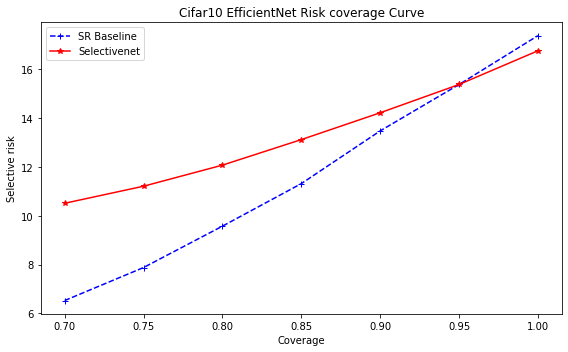

In [314]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
# ax.plot(coverages,ebr_coverages_risk[:,1],color='blue', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='blue', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='red', linestyle='--',marker='*',label='Sel SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 EfficientNet Risk coverage Curve')
plt.tight_layout()
plt.show()

### SR model

In [239]:
# from effnet_SR import SR_model
def SR_model(num_classes, dropout,mc_dropout, input_dim, training, pooling='avg'):
    inputs=Input(input_dim)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable=True
    x = base_model.output
    x = Dropout(dropout, name='top_dropout_1')(x,training=training)
    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='max_pool')(x)   
    x = Dropout(dropout, name='top_dropout_2')(x,training=training)
    x = Dense(512,activation='relu', name='dense_512')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout, name='top_dropout_3')(x,training=training)
    x = Lambda(lambda x: K.dropout(x, level=mc_dropout))(x)

    #classification head (f)
    sr = Dense(num_classes,activation='softmax', name='dense_f')(x) 
    return Model(inputs=inputs,outputs=sr)

In [240]:
sr_model_efficientnet=SR_model(num_classes=len(CLASS_NAMES),dropout=dropout,mc_dropout=mc_dropout,input_dim=IMG_SHAPE,training=True)

In [241]:
# sr_model_efficientnet.summary()

In [242]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=momentum, nesterov=True)
sr_model_efficientnet.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [255]:
historytemp = sr_model_efficientnet.fit(train_images, tr_labels,
                          steps_per_epoch=stepsperepoch,
                          epochs=maxepoches,validation_split=0.2, callbacks=[reduce_lr])

In [244]:
sr_model_efficientnet.save_weights("saved_data/{}".format('cifar10_effnet_SR.h5'))

In [245]:
header =",".join(["accuracy","loss","val_accuracy", "val_loss\n"])
sr_history=save_dir+'/cifar10_effnet_sr_history.csv'
f=open(sr_history,"w")
f.write(header)
f.close()

In [246]:
a=np.array([
    historytemp.history['accuracy'],
    historytemp.history['loss'],
    historytemp.history['val_accuracy'],
    historytemp.history['val_loss']
]).T
write_csv(sr_history,a)

### SR learning curve

In [247]:
sr_curve=pd.read_csv(sr_history)

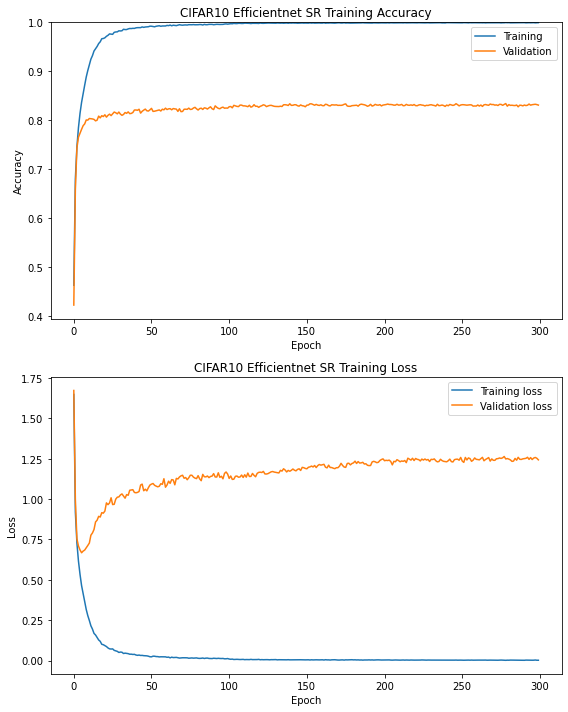

In [248]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='-', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('CIFAR10 Efficientnet SR Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('CIFAR10 Efficientnet SR Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [249]:
predictions= sr_model_efficientnet.predict(test_images) #set predictions for use

In [250]:
y_true = np.argmax(ts_labels,axis=1)
y_pred = np.argmax(predictions,axis=1)
print("SR predictions: ",y_pred.shape)      

SR predictions:  (10000,)


In [251]:
acc=my_evaluation(y_true,np.argmax(predictions,axis=1))
print("Accuracy:",acc)

Accuracy: 0.8301


In [252]:
esr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    esr_coverages_risk[i]= sr_selective_risk(c,ts_labels,predictions,mc=True)
    i=i+1

In [254]:
esr_coverages_risk

array([[0.4962    , 0.02519146, 0.97480854],
       [0.5499    , 0.03127841, 0.96872159],
       [0.5999    , 0.03933989, 0.96066011],
       [0.6499    , 0.0489306 , 0.9510694 ],
       [0.6999    , 0.05757965, 0.94242035],
       [0.7499    , 0.07267636, 0.92732364],
       [0.7999    , 0.08838605, 0.91161395],
       [0.8499    , 0.10507118, 0.89492882],
       [0.8999    , 0.1241249 , 0.8758751 ],
       [0.9499    , 0.14780503, 0.85219497],
       [0.9999    , 0.16981698, 0.83018302]])

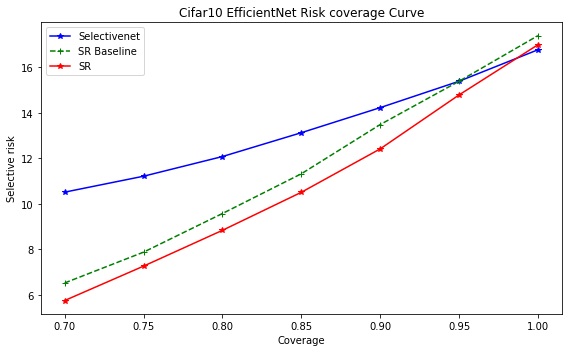

In [312]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(coverages[4:],esel_coverage_risk[4:,1]*100,color='blue', linestyle='-',marker='*',label='Selectivenet')
# ax.plot(coverages,esel_sr_coverages_risk[:,1],color='blue', linestyle='--',marker='+',label='Sel SR')
# ax.plot(coverages,ebr_coverages_risk[:,1],color='green', linestyle='-',marker='*',label='Baseline Selectivenet')
ax.plot(coverages[4:],ebr_sr_coverages_risk[4:,1]*100,color='green', linestyle='--',marker='+',label='SR Baseline')
ax.plot(coverages[4:],esr_coverages_risk[4:,1]*100,color='red', linestyle='-',marker='*',label='SR')
ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Cifar10 EfficientNet Risk coverage Curve')
plt.tight_layout()
plt.show()